# I4 Fairness: German dataset

Student: Maria Lara (mlaracue)
<br>Date: 4/16/2022

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

## Data loading

In [2]:
col_names = [
    "status",
    "duration",
    "credithistory",
    "purpose",
    "amount",
    "savingsaccnt",
    "jobtenure",
    "installmentrate",
    "statussex",
    "guarantors",
    "residence",
    "property",
    "age",
    "otherinstallment",
    "housing",
    "nocredits",
    "job",
    "dependents",
    "telephone",
    "foreign",
    "default"
]

In [3]:
df = pd.read_csv("./data/german.data", sep=" ", names=col_names, index_col=False)
df.dtypes

status              object
duration             int64
credithistory       object
purpose             object
amount               int64
savingsaccnt        object
jobtenure           object
installmentrate      int64
statussex           object
guarantors          object
residence            int64
property            object
age                  int64
otherinstallment    object
housing             object
nocredits            int64
job                 object
dependents           int64
telephone           object
foreign             object
default              int64
dtype: object

## EDA: Default rate by protected attributes

Before I start training the model, I'd like to get a proxy for any historical bias; i.e., bias already existing in the data and that will very likely influence the learning process. For that, I look at the default rate broken down by the two protected attributes gender and age.

In [4]:
# Transform default to binary
df["default"] = (df["default"] == 2).astype(int)

# Create gender column (1 male, 0 female)
df["gender"] = df["statussex"].apply(lambda x: 1 if x in ["A91", "A93", "A94"] else 0)

# Drop statussex column to avoid multicollinearity
df = df.drop(columns=["statussex"])

In [5]:
# Average default rate
default_rate = df["default"].mean()
print(f"Average default rate: {default_rate:.2f}")

Average default rate: 0.30


### Gender

We see below that the default rate among females is substantially higher than for males. However, there's some overlap in the 95% confidence intervals, suggesting that the observed difference might be due to chance.  

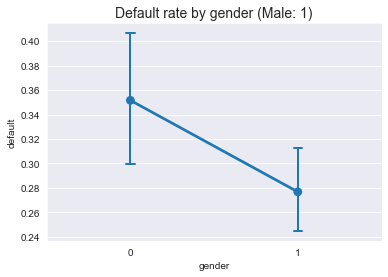

In [6]:
sns.pointplot(x="gender", y="default", data=df, capsize=.05, errwidth=2, ci=95)
plt.title("Default rate by gender (Male: 1)", fontsize=14)
plt.show()

### Age

For age, on the other hand, what we see is that as the age increases, the default rate decreases. Note that individuals 55+ years old are not representative enough in the sample and, as such, we shouldn't make any strong claims about their default rate. 

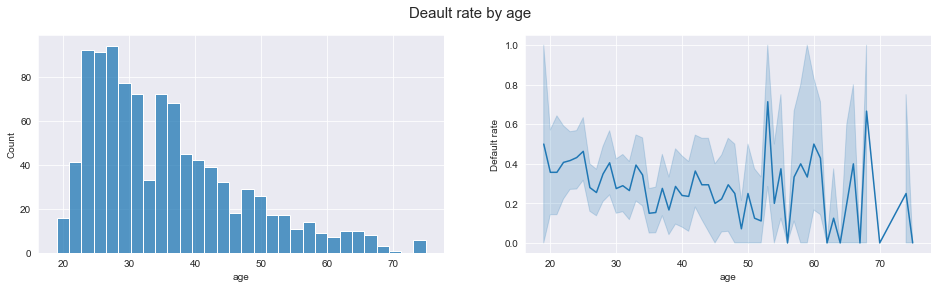

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(df["age"], bins=30, ax=ax[0])
sns.lineplot(x="age", y="default", data=df, ax=ax[1])
ax[1].set_xlabel("age"); ax[1].set_ylabel("Default rate")
fig.suptitle("Deault rate by age", fontsize=15)
plt.show()

To gain further insight, I create a categorical variable by dividing age into 5 quantiles. We can see that as the age increases, the default rate also increases, even considering that age categories are all between 15-25% (i.e., these results are not necessarily influenced by under-represented, and unstable estimates for an age category).

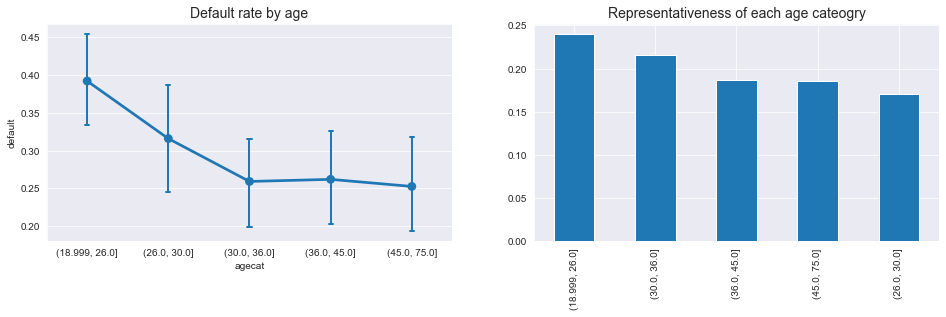

In [8]:
# Dividing age in 5 quantiles to define bins
df["agecat"] = pd.qcut(df["age"], q=5, retbins=False)

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.pointplot(x="agecat", y="default", data=df, capsize=.05, errwidth=2, ci=95, ax=ax[0])
ax[0].set_title("Default rate by age", fontsize=14)

df["agecat"].value_counts(normalize=True).plot(kind="bar", ax=ax[1])
ax[1].set_title("Representativeness of each age cateogry", fontsize=14)
plt.show()

Finally, I converted age into a binary variable where younger people (below 30 years) belong to the *unprivileged group* in the protected attribute `age`

In [9]:
# Create age binary group based on results above
df["agebin"] = df["age"].apply(lambda age: 1 if age >= 30 else 0)

## Modeling

### Preprocessing

In [10]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

from scipy.stats import uniform
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [11]:
# Convert categorical columns to OHE
categorical_vars = df.select_dtypes(include=["object"]).columns

df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# Drop response column and other numerical columns that won't be used
drop_cols = ["default", "age", "agecat"]
df_dummies = df_dummies.drop(columns=drop_cols)

# Extract values from Xs
X = df_dummies.values

# Get response variable
y = df["default"].values

In [12]:
SPLIT_RATIO = 0.33

# Split into training (67%), test (16.5%), and validation set (16.5%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_RATIO, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training size: {:,}. Validation size: {:,}. Test size: {:,}".format(len(y_train), len(y_val), len(y_test)))

Training size: 670. Validation size: 165. Test size: 165


In [13]:
# Apply standard scaler to avoid scale-related problems
scaler = StandardScaler()
# Fit on training data
X_train = scaler.fit_transform(X_train)

# Apply transformer to validation and test set
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 1. Baseline model: Logistic Regression
No fairness constraints

### Cross-validation

In [14]:
%%time
parameters = {
    "C": uniform(loc=0, scale=4),
    "penalty": ["l2", "l1"]
}

logit = LogisticRegression(solver="saga", tol=1e-2, max_iter=500, random_state=42)
cv = RandomizedSearchCV(logit, parameters, cv=LeaveOneOut(), random_state=42)
cv.fit(X_train, y_train)

print(f"Best score {cv.best_score_:.3f} at {cv.best_params_}")

Best score 0.743 at {'C': 1.49816047538945, 'penalty': 'l2'}
CPU times: total: 46.4 s
Wall time: 47.6 s


### Model performance on validation data

Below I'm showing the calibration and the ROC curves; for the former, if well calibrated (close to the 45-degree line), the probabilities reflect the true likelihood of the outcome. The ROC curve, on the other hand, allows us to get an estimate of the model's performance without having to comit to a single threshold.

First of all, it seems that probabilities are not well-calibrated and as such, may the reflect the true likelihood of the outcome.

For the ROC curve, on the other hand, we see that Area Under the Curve (AUC) is 0.78 which, according to the reference value mentioned in the handout, it seems to be a good-enough performance.

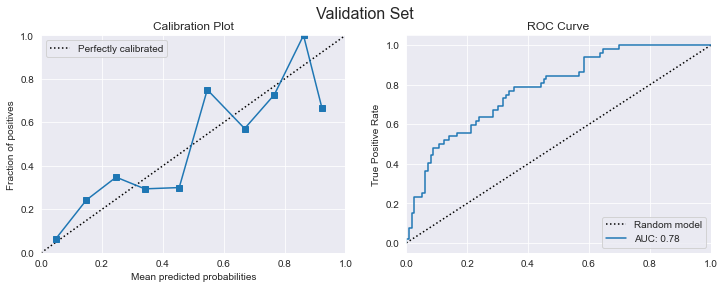

In [15]:
# Get scores for validation set
y_val_scores = cv.predict_proba(X_val)[::,1]

# Compute ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_scores)
auc = metrics.roc_auc_score(y_val, y_val_scores)

# If well calibrated, the probabilities reflect the true likelihood of the outcome.
fp_0, mpv_0 = calibration_curve(y_val, y_val_scores, n_bins = 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
ax[0].plot(mpv_0, fp_0, 's-')
ax[0].set_ylabel('Fraction of positives')
ax[0].set_xlabel('Mean predicted probabilities')
ax[0].set_xlim([0,1]); ax[0].set_ylim([0,1])
ax[0].legend(loc='upper left')
ax[0].set_title("Calibration Plot", fontsize=12)

ax[1].plot([0,1], [0,1], 'k:', label="Random model")
ax[1].plot(fpr, tpr, label=f"AUC: {auc:.2f}")
ax[1].set_ylabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_xlim([0,1]); ax[1].set_xlim([0,1])
ax[1].legend(loc="lower right")
ax[1].set_title("ROC Curve", fontsize=12)

plt.suptitle("Validation Set", fontsize=16)
plt.show()

#### Optimizing threshold

Given that there's some imbalance in the sample (7:3 ratio between negative and positive instances), I use the balanced accuracy as my measure of model performance. For that, I first need to decide on a single threshold to classify applicants as either "good" or "bad" (being *bad* my class of interest). Henceforth, I optimize the threshold such that the total cost (using the cost matrix) is minimized.

In [16]:
cost_matrix = np.array([[0, 1], [5, 0]])
def cost_function(y_true, y_pred) -> int:
    cost = metrics.confusion_matrix(y_true, y_pred) * cost_matrix
    return cost.sum()

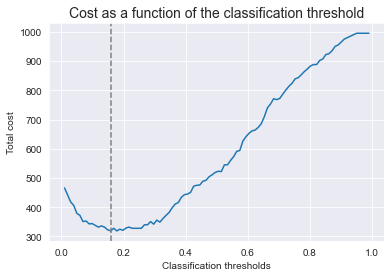

Best threshold: 0.158


In [17]:
y_train_scores = cv.predict_proba(X_train)[::,1]

cost_array = []
thresholds = np.linspace(0.01, 0.99, 100)
for thresh in thresholds:
    y_pred = (y_train_scores > thresh).astype(int)
    cost_array.append(cost_function(y_train, y_pred))

# Get index with lowest cost
idx = np.argmin(cost_array)
# Get best threshold
best_threshold = thresholds[idx]

# Plot results
plt.plot(thresholds, cost_array)
plt.xlabel("Classification thresholds")
plt.ylabel("Total cost")
plt.axvline(best_threshold, linestyle="--", color="gray")
plt.title("Cost as a function of the classification threshold", fontsize=14)
plt.show()

print(f"Best threshold: {best_threshold:.3f}")

#### Balanced accuracy score

The balanced accuracy score deals with imbalanced datasets. It is defined as the average of recall obtained on each class.

In [18]:
y_val_pred = (y_val_scores > best_threshold).astype(int)
accuracy = metrics.balanced_accuracy_score(y_val, y_val_pred)
print(f"Balanced accuracy on validation set: {accuracy:.2f}")

Balanced accuracy on validation set: 0.68


## 2. Fairness measures

### a) Anti-classification

Anti-classification basically states: *don't use protected categories to make decisions/predictions*. It's also known as "fairness through unawareness" [1]. Testing for anti-classification:

$$\forall x,  f(x[p \leftarrow 0]) =  f(x[p \leftarrow 1])$$

References: [1] Ninareh Mehrabi et al., “A Survey on Bias and Fairness in Machine Learning,” ArXiv:1908.09635 [Cs], January 25, 2022, http://arxiv.org/abs/1908.09635.

#### Gender

To test for anti-classification in the baseline model, I'll change simply assing to "female" all the male instances, and see how the predicted probabilities change.

In [19]:
# Get predicted probabilities for males
gender_idx = df_dummies.columns.tolist().index("gender")
# Get male instances
males = np.where(df["gender"] == 1)[0]
male_instances = X[males,:]
males_probs = cv.predict_proba(scaler.transform(male_instances))[::,1]

# Assign gender to zero (i.e., female)
male_instances[:,gender_idx] = 0
males_probs_counterfactual = cv.predict_proba(scaler.transform(male_instances))[::,1]

We see on the histogram below that by assigning male instances to females the predicted probabilities are, for all of them, higher.<br>This might suggest bias towards females since by simply changing the value of the protected attribute to the unprivileged group (females), the probability of default is higher.

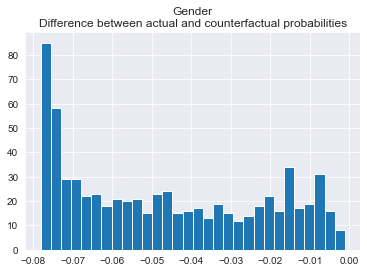

In [20]:
plt.hist(males_probs - males_probs_counterfactual, bins=30)
plt.title("Gender\nDifference between actual and counterfactual probabilities")
plt.show()

In [21]:
# Calculate for how many instances the difference between 
# the probabilities is different from zero with a tolerance of 0.01
inconsistencies = ~np.isclose((males_probs - males_probs_counterfactual), b=0, atol=1e-02)

print("Percentage of inconsistencies: %.1f%%" % (inconsistencies.mean() * 100))

Percentage of inconsistencies: 90.7%


#### Age

For each the treatment is similar; the difference is that all the "older" individuals (30+) are assigned to "young" (`agebin` = 0).<br> Then, I analyze once again how the predicted probabilities change.

In [22]:
age_idx = df_dummies.columns.tolist().index("agebin")

# Get "older" instances
older = np.where(df["agebin"] == 1)[0]
older_instances = X[older,:]
older_probs = cv.predict_proba(scaler.transform(older_instances))[::,1]

# Assign gender to the underpivileged class
older_instances[:,age_idx] = 0
older_probs_counterfactual = cv.predict_proba(scaler.transform(older_instances))[::,1]

As before, when individuals are assigned to the underprivileged class, remaining all the other covariables unchanged, the default probability is higher (negative values).

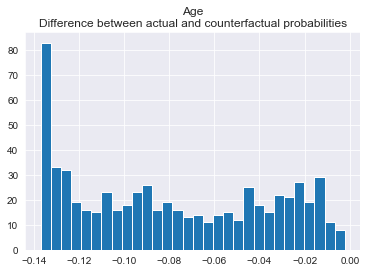

In [23]:
plt.hist(older_probs - older_probs_counterfactual, bins=30)
plt.title("Age\nDifference between actual and counterfactual probabilities")
plt.show()

In [24]:
# Calculate for how many instances the difference between 
# the probabilities is different from zero with a tolerance of 0.01
inconsistencies = ~np.isclose((older_probs - older_probs_counterfactual), b=0, atol=1e-02)

print("Percentage of inconsistencies: %.1f%%" % (inconsistencies.mean() * 100))

Percentage of inconsistencies: 97.6%


### b) Group fairness

$$P[\hat{Y} = 1 | A = a] = P[\hat{Y} = 1 | A = b]$$

To achieve group fairness, the predicted probability $\hat{Y}$ for two classes $a$ and $b$ for a protected attribute $A$ must be equal.

From the results below, we saw that for both `gender` and `agebins`, the difference in default rate favors the privileged group.

Test for gender:
	Privileged: 0.273
	Unprivileged: 0.350
Difference (unprivileged - privileged): 0.0777


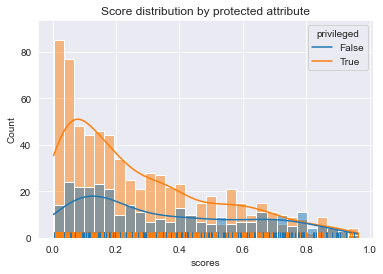

False

In [25]:
# Compute probabilities for all observations
scores_all = cv.predict_proba(scaler.transform(X))[::,1]
    
def test_group_fairness(attribute: str, scores_all: np.array) -> bool:
    # Get mask for privileged group
    mask = (df[attribute] == 1).values
    # Get mean probability for privileged group
    privileged = scores_all[mask].mean()
    # Get mean probability for unprivileged group
    unprivileged = scores_all[~mask].mean()
    # Compute difference
    difference = unprivileged - privileged
    # Print results
    print(f"Test for {attribute}:")
    print(f"\tPrivileged: {privileged:.3f}\n\tUnprivileged: {unprivileged:.3f}")
    print(f"Difference (unprivileged - privileged): {difference:.4f}")
    
    scores_df = pd.DataFrame({"scores": scores_all, "privileged": mask})
    sns.histplot(data=scores_df, x="scores", hue="privileged", kde=True, bins=30)
    sns.rugplot(data=scores_df, x="scores", hue="privileged")
    plt.title("Score distribution by protected attribute")
    plt.show()
    
    # Test whether they're equal with a tolerance of 0.01
    return np.isclose(unprivileged, privileged, atol=1e-02)

test_group_fairness("gender", scores_all)

Test for agebin:
	Privileged: 0.244
	Unprivileged: 0.387
Difference (unprivileged - privileged): 0.1428


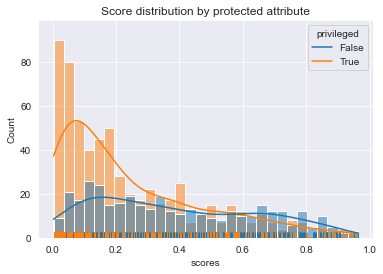

False

In [26]:
test_group_fairness("agebin", scores_all)

### c) Separation

Here we're interested in that the probability of a person in the positive class being correctly assigned a positive outcome (true positives) and the probability of a person in a negative class being incorrectly assigned a positive outcome (false positives) should both be the same for the protected and unprotected group members.

$$P[\hat{Y} = 1 | Y = y, A = a] = [\hat{Y} = 1 | Y = y, A = b]. y\in \{ 0, 1 \}$$

**Assumption:** For now, I'll use the threshold found above, optimized to minimize the total cost.

In [27]:
# Get labels for all instances
labels = (scores_all > best_threshold).astype(int)
    
def tpr_fpr(matrix: np.array):
    tn, fp, fn, tp = matrix.ravel()
    # False positive rate
    tpr = tp / (tp + fn)
    # True negative rate
    tnr = tn / (tn + fp)
    # False positive rate
    fpr = 1 - tnr
    return tpr, fpr

def test_separation(
    attribute: str, 
    labels_true: np.array, 
    labels_predicted: np.array, 
    df: pd.DataFrame = df, 
    print_results: bool = True
):
    """
    Compute TPR and FPR by the privileged and unprivileged 
    classes of the protected attribute. 
    
    Args:
        attribute (str): The protected attribute found in the df
        labels_true (np.array): The true labels for all instances in df
        labels_predicted (np.array): The predicted labels for all instances in df
        df: a pandas DataFrame with the protected attribute
        print_results (bool): Whether to print the results
    
    Returns:
        Tuple with difference for tpr, fpr and whether these rates are equal
            for the privileged and unprivileged groups.
    """
    # Get mask for privileged group
    mask = (df[attribute] == 1).values
    
    # Get true and predicted labels for privileged group
    privileged_true = labels_true[mask]
    privileged_predicted = labels_predicted[mask]
    
    # Get TPR and FPR for privileged group
    matrix = metrics.confusion_matrix(privileged_true, privileged_predicted)
    privileged_tpr, privileged_fpr = tpr_fpr(matrix)
    
    # Get true and predicted labels for unprivileged group
    unprivileged_true = labels_true[~mask]
    unprivileged_predicted = labels_predicted[~mask]
    
    # Get TPR and FPR for unprivileged group
    matrix = metrics.confusion_matrix(
        unprivileged_true, unprivileged_predicted)
    
    unprivileged_tpr, unprivileged_fpr = tpr_fpr(matrix)
    
    # Difference for TPR
    diff_tpr = unprivileged_tpr - privileged_tpr
    
    # Difference for FPR
    diff_fpr = unprivileged_fpr - privileged_fpr
    
    # Print results
    if print_results:
        print(f"Test for {attribute}:")
        print("True Positive Rates:")
        print(f"\tPrivileged: {privileged_tpr:.3f}\n\tUnprivileged: {unprivileged_tpr:.3f}")
        print(f"\tDifference (unprivileged - privileged): {diff_tpr:.4f}")

        print("False Positive Rates:")
        print(f"\tPrivileged: {privileged_fpr:.3f}\n\tUnprivileged: {unprivileged_fpr:.3f}")
        print(f"\tDifference (unprivileged - privileged): {diff_fpr:.4f}")
    
    # Test whether they're equal with a tolerance of 0.01
    is_equal = (
        np.isclose(unprivileged_tpr, privileged_tpr, atol=1e-02) and 
        np.isclose(unprivileged_fpr, privileged_fpr, atol=1e-02)
    )
    
    return diff_tpr, diff_fpr, is_equal

test_separation("gender", df["default"], labels)

Test for gender:
True Positive Rates:
	Privileged: 0.874
	Unprivileged: 0.927
	Difference (unprivileged - privileged): 0.0523
False Positive Rates:
	Privileged: 0.459
	Unprivileged: 0.537
	Difference (unprivileged - privileged): 0.0784


(0.052259954848936085, 0.07839559716447819, False)

In [28]:
test_separation("agebin", df["default"], labels)

Test for agebin:
True Positive Rates:
	Privileged: 0.865
	Unprivileged: 0.927
	Difference (unprivileged - privileged): 0.0620
False Positive Rates:
	Privileged: 0.403
	Unprivileged: 0.637
	Difference (unprivileged - privileged): 0.2333


(0.0619766244234472, 0.23331866035728688, False)

## 3. Improving model fairness for age

### a) Anti-classification

Being also called "fairness by unawareness", the idea is not to use information about the protected attributes when training the model. Additionally, one of the maind drawbacks is that there might be other correlated features with `age` which the model may capture during the learning procress. Hence, we first evaluate the correlation between age and other attributes.

From the results below, it seems there are not features highly correlated with age, so removing `agebin` from the learning process might be enough.

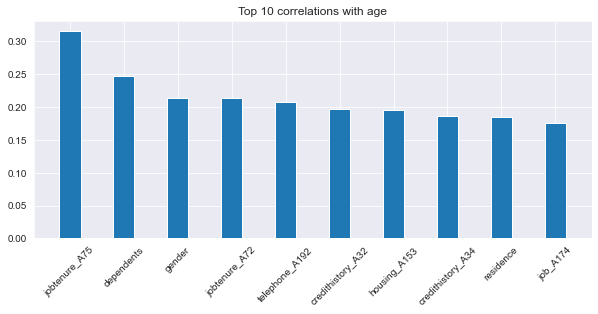

In [29]:
corr_matrix = pd.DataFrame(X_train).corr()
age_corr = corr_matrix.iloc[age_idx,:].abs()
sorted_idx = age_corr.argsort()[::-1][1:11]

plt.figure(figsize=(10, 4))
plt.bar(df_dummies.columns[sorted_idx], age_corr[sorted_idx], width=.4)
plt.xticks(rotation=45)
plt.title("Top 10 correlations with age")
plt.show()

In [31]:
X_train_age = np.delete(X_train, age_idx, axis=1)
cvfair = RandomizedSearchCV(logit, parameters, cv=LeaveOneOut(), random_state=42)
cvfair.fit(X_train_age, y_train)

print(f"Best score {cvfair.best_score_:.3f} at {cvfair.best_params_}")

Best score 0.745 at {'C': 1.49816047538945, 'penalty': 'l2'}


#### Counterfactuals using $k$-nearest neighbors

With the new model, we know evaluate counterfactual instances to see if the predicted probability increases when the individual is assigned to the unprivileged class "younger". The problem we face, however, is that now we don't have an age attribute for which we can flip the classess for the protected attribute. Therefore, I'll use $k$NN to find the 5 closest instances to each privileged individual $i$ and compute the difference as:

$$\hat{y}_i - \frac{1}{\text{5}} \sum_{j\in\mathcal{N}_{\text{5}}(x_i)} \hat{y}_j$$

Please note that the neighbors are found using the *unprivileged* individuals. What this means is that for each privileged individual I'll find the 5 unprivileged individuals that are closes to it, to control for other covariables.

In [32]:
from sklearn.neighbors import NearestNeighbors

In [33]:
# Get mask for privileged group
mask = (df["agebin"] == 1).values
    
# Remove age from all instances
X_age = np.delete(scaler.transform(X), age_idx, axis=1)

# Get probabilities for instances with new model
y_pred_age = cvfair.predict_proba(X_age)[::,1]

# Initialize and fit the kNN algorithm with unprivileged instances
nn = NearestNeighbors(n_neighbors=5, algorithm="ball_tree")
nn.fit(X_age[~mask, :])

# Get the indices of the neighbors from privileged instances 
_, indices = nn.kneighbors(X_age[mask])

From the results below, we see that unprivileged individuals have predicted probabilities above and below the privileged ones. Hence, the percentage of inconsistencies (which looks for the difference to be near zero) is still very large.

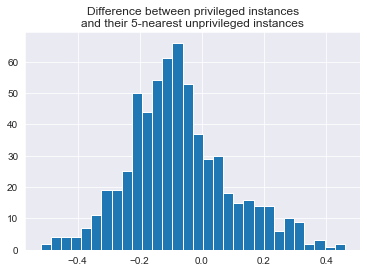

Percentage of inconsistencies: 97.9%


In [34]:
y_pred_privileged = y_pred_age[mask]
y_pred_unprivileged = y_pred_age[~mask]

# Compute the difference between each instance and its neighbors
n_samples = sum(mask)
difference = [y_pred_privileged[idx] - y_pred_unprivileged[indices[idx]].mean() for idx in range(n_samples)]

plt.hist(difference, bins=30)
plt.title("Difference between privileged instances\nand their 5-nearest unprivileged instances")
plt.show()

# Calculate for how many instances the difference between 
# the probabilities is different from zero with a tolerance of 0.01
inconsistencies = ~np.isclose(difference, b=0, atol=1e-02)

print("Percentage of inconsistencies: %.1f%%" % (inconsistencies.mean() * 100))

### b) Group fairness

To ensure group fairness during the learning process, I'll use the [Disparate Impact Remover](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html) transformer from the AIF360 IBM Toolkit. This transformer edits feature values to increase group fairness while preserving rank-ordering within groups.

In [35]:
from aif360.datasets import BinaryLabelDataset 
from aif360.algorithms.preprocessing import DisparateImpactRemover

C:\Users\makue\Documents\aif360\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [36]:
# Convert dataframes to AIF360 data structures
train_df = pd.DataFrame(X_train, columns=df_dummies.columns)
train_df["y"] = y_train

val_df = pd.DataFrame(X_val, columns=df_dummies.columns)
val_df["y"] = y_val

# Initialize BinaryLabelDataset structure
dataset_train = BinaryLabelDataset(df=train_df, label_names=["y"], protected_attribute_names=["agebin"])
dataset_val = BinaryLabelDataset(df=val_df, label_names=["y"], protected_attribute_names=["agebin"])

In [37]:
# Initialize transformer
transformer = DisparateImpactRemover(sensitive_attribute="agebin")
# Apply transformer to training data
dataset_train_trnsf = transformer.fit_transform(dataset_train)

In [38]:
# Train a new classifier
logit_fair = RandomizedSearchCV(logit, parameters, cv=LeaveOneOut(), random_state=42)
logit_fair.fit(dataset_train_trnsf.features, dataset_train_trnsf.labels.flatten())

print(f"Best score {logit_fair.best_score_:.3f} at {logit_fair.best_params_}")

Best score 0.746 at {'C': 0.7337391594646552, 'penalty': 'l1'}


As we can see from the results below, the difference in the outcome probabilities between the privileged and unprivileged groups decreased by ~7.6%, which is better than we had before.

Test for agebin:
	Privileged: 0.249
	Unprivileged: 0.381
Difference (unprivileged - privileged): 0.1327


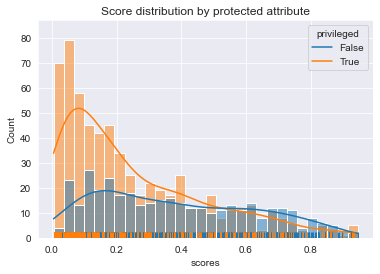

False

In [39]:
%matplotlib inline

# Compute probabilities for all observations
df_all = pd.DataFrame(scaler.transform(X), columns=df_dummies.columns)
df_all["y"] = y

dataset = BinaryLabelDataset(df=df_all, label_names=["y"], protected_attribute_names=["agebin"])
dataset_trnsf = transformer.fit_transform(dataset)
scores_all_fair = logit_fair.predict_proba(dataset_trnsf.features)[::,1]
    
test_group_fairness("agebin", scores_all=scores_all_fair)

In [40]:
(0.1327 - 0.1428) / 0.1327 * 100

-7.611152976639033

### c) Separation

For separation, I'll optimize the threshold using the training data such that the difference in TPR and FPR is minimized. The scores are those predicted by the baseline classifier (with no fairness constraints).

In [41]:
X_train_original = scaler.inverse_transform(X_train)
train_df_original = pd.DataFrame(X_train_original, columns=df_dummies.columns)

tpr_diff_array = []
fpr_diff_array = []
thresh_used = []

thresholds = np.linspace(0.05, 0.95, 100)
for thresh in thresholds:
    labels = (y_train_scores > thresh).astype(int)
    try:
        diff_tpr, diff_fpr, _ = test_separation(
            "agebin", 
            y_train, labels, 
            df=train_df_original, 
            print_results=False
        )
        tpr_diff_array.append(diff_tpr)
        fpr_diff_array.append(diff_fpr)
        thresh_used.append(thresh)
    except ValueError:
        continue

As we see from the plot below, there's no single threshold that minimizes the difference between unprivileged and privileged groups for both $TPR$ and $FPR$. This is expected since there's a trade-off between these two metrics. 

However, we can select a threshold that allows the differences to be between ±0.1, as shown with the shaded area.


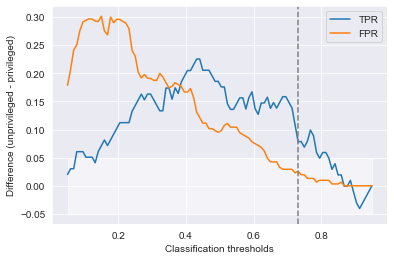

Best threshold: 0.732


In [42]:
candidates = np.logical_and(
    np.isclose(tpr_diff_array, 0, atol=.1),
    np.isclose(fpr_diff_array, 0, atol=.1)
)
best_threshold = np.array(thresh_used)[candidates][0]

# Plot results
plt.plot(thresh_used, tpr_diff_array, label="TPR")
plt.plot(thresh_used, fpr_diff_array, label="FPR")
plt.legend()
plt.xlabel("Classification thresholds")
plt.ylabel("Difference (unprivileged - privileged)")
plt.fill_between(thresh_used, y1=-.05, y2=.05, color=(1, 1, 1, 0.5))
plt.axvline(best_threshold, linestyle="--", color="gray")
plt.show()

print(f"Best threshold: {best_threshold:.3f}")

As noted by other authors [2][3] there's a trade-off between fairness and performance. Therefore, as a result from the threshold optimization done above, what we see is that we can achieve fairness on both protected and unprotected classes only by sacrificing the model's performance; the classifier is fair but not significantly better than a random classifier.

**References:**<br>
[2] Machine Learning Department University Carnegie Mellon, “FACT Diagnostic: How to Better Understand Trade-Offs Involving Group Fairness,” Machine Learning Blog | ML@CMU | Carnegie Mellon University (blog), October 12, 2020, https://blog.ml.cmu.edu/2020/10/12/fact-diagnostic-how-to-better-understand-trade-offs-involving-group-fairness/.<br>
[3] “When and How Do Fairness-Accuracy Trade-Offs Occur?,” accessed April 18, 2022, https://wearepal.ai/blog/when-and-how-do-fairness-accuracy-trade-offs-occur.

In [43]:
labels = (scores_all > best_threshold).astype(int)
test_separation("agebin", df["default"], labels)

accuracy = metrics.balanced_accuracy_score(y, labels)
print(f"\nBalanced accuracy score: {accuracy:.3f}")

Test for agebin:
True Positive Rates:
	Privileged: 0.153
	Unprivileged: 0.263
	Difference (unprivileged - privileged): 0.1094
False Positive Rates:
	Privileged: 0.013
	Unprivileged: 0.038
	Difference (unprivileged - privileged): 0.0256

Balanced accuracy score: 0.591
